In [1]:
from __future__ import print_function,division
import torch
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy
from torch.utils.data.dataset import random_split

In [2]:
import tqdm

In [3]:


def cv2_transform(image):
    #print(type(image))
    px= np.array(image.getdata(),np.uint8).reshape(image.size[0], image.size[1], 3)
    #image = image.numpy().reshape([64,64,3])
    #print(image)
    #print(px.shape)
    #image=Image.fromarray(image)
    #print(px)
    image = cv2.cvtColor(px,cv2.COLOR_RGB2BGR)
    #cv2.imshow('f',image)
    #return 
    weed_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    sensitivity = 39
    a =np.array([60 - sensitivity, 100, 50])  #lower_Range
    b=np.array([60 + sensitivity, 255, 255]) # upper_Range
    mask = cv2.inRange(weed_hsv,a,b)

    res_w = cv2.bitwise_and(image,image,mask= mask)
    res_w = cv2.cvtColor(res_w,cv2.COLOR_BGR2RGB)
    res_w=Image.fromarray(np.array(res_w,np.uint8))

    
    return res_w

In [14]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2

class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):      
    # store filenames
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames]

    # the first character of the filename contains the label
        self.labels = [ filename.split('/')[-1] for filename in self.filenames]
        self.transform = transform

    def __len__(self):
    # return size of dataset
        return len(self.filenames)
    

    def __getitem__(self, idx):
    # open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        #print(type(np.array(image)))
        #image = self.cv2_transform(image)
        image = self.transform(image)
        #image = self.cv2_transform(image)
        return image, self.labels[idx]


train_transformer = transforms.Compose([
    transforms.Lambda(lambda x : cv2_transform(x)),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    #transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    

])             # transform it into a PyTorch Tensor

train_data_path = 'test'
train_dataset = SIGNSDataset(train_data_path, train_transformer)

test_dataloader = DataLoader(SIGNSDataset(train_data_path, train_transformer), 
                              batch_size=4, shuffle=False,
                              num_workers=4)

In [5]:
lst = []
for input_,cltest_dataloader in test_dataloader:
    out = model_conv(input_)
    pred = t.max(out,1)
    out_class = class_names[pred]
    lst.append(zip(classes,out_class))

NameError: name 'model_conv' is not defined

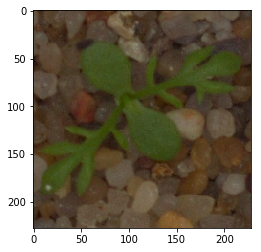

In [6]:
#Original Image without any transformation

weed= cv2.imread('weed2.png',cv2.IMREAD_COLOR)
weed1 = cv2.cvtColor(weed,cv2.COLOR_BGR2RGB)
plt.imshow(weed1)
plt.show()

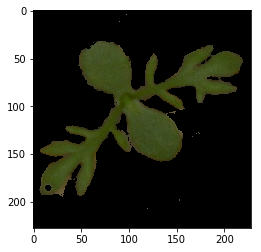

In [7]:
# WITH COLOR FILTERING

weed_hsv = cv2.cvtColor(weed,cv2.COLOR_BGR2HSV)
sensitivity = 39
a =np.array([60 - sensitivity, 100, 50])  #lower_Range
b=np.array([60 + sensitivity, 255, 255]) # upper_Range
mask = cv2.inRange(weed_hsv,a,b)

res_w = cv2.bitwise_and(weed1,weed1,mask= mask)
plt.imshow(res_w)
plt.show()

In [8]:
data_transform = {'train': transforms.Compose([
    transforms.Lambda(lambda x : cv2_transform(x)),
    
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    
    
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    #transforms.LinearTransformation()
])}

data_dir = 'train'
image_dataset = {'train':datasets.ImageFolder(os.path.join(data_dir),data_transform['train'])}
## creating placeholder keep length of original dataset
train_dataset_len = len(image_dataset['train'])
class_names = image_dataset['train'].classes
len_train = (train_dataset_len*3)//4
image_dataset['train'],image_dataset['val'] = random_split(image_dataset['train'],[len_train,train_dataset_len-len_train])
dataloader = {x: t.utils.data.DataLoader(image_dataset[x],batch_size=4,shuffle=True,num_workers=4)
             for x in ['train','val']}
dataset_sizes = {x:len(image_dataset[x]) for x in ['train','val']}
#class_names = image_dataset['train'].classes
device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')

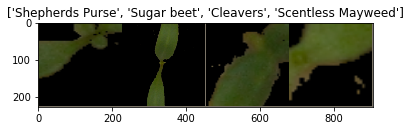

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

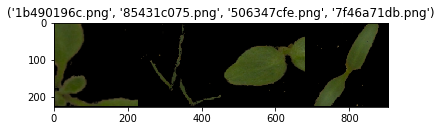

In [17]:
# Visualize a Test images  images 
def imshow(inp,title=None):
    inp = inp.numpy().transpose([1,2,0])
    #print(inp.shape)
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    #inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

    #print(train_bta.shape)
train_bta,label_bta=next(iter(test_dataloader))    
out = torchvision.utils.make_grid(train_bta,nrow=16)
imshow(out,title=label_bta)
    

In [25]:
from tqdm import tqdm,trange

In [ ]:
##Validation dataset
inputs,classes = next(iter(dataloader['val']))
out  = torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes ])

In [14]:
# Training the model

def train_model(model,criterion,optimizer,scheduler,num_epochs=2):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        #Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train() ## set model in training mode
            else:
                model.eval() ##set model to evaluate mode
            
            running_loss = 0.0
            running_corrections = 0
            
            #Iterate over data
            for inputs,labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradient
                optimizer.zero_grad()
                
                #forward
                # track history if only in train
                with t.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    
                    if phase =='train':
                        loss.backward()
                        optimizer.step()
                        
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrections += t.sum(labels.data == pred)
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrections.double()/dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            ## deep_copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
    time_e = time.time() - since    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_e //60,time_e%60))
    print('Best Accuracy: {:.4f}'.format(best_acc))

    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_con =  models.resnet50(pretrained=True)
for param in model_con.parameters():
    param.requires_grad = False
    
    
num_ftrs = model_con.fc.in_features
model_con.fc = nn.Linear(num_ftrs,len(class_names))
print(model_con.fc.in_features)
model_con = model_con.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_con.fc.parameters(),lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)



2048


In [16]:
model_conv= train_model(model_con,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=20)

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 1.5788 Acc 0.5438


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 1.0377 Acc 0.7180
Epoch 1/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.9232 Acc 0.7302


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.7950 Acc 0.7803
Epoch 2/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.7652 Acc 0.7664


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.6940 Acc 0.7946
Epoch 3/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.6948 Acc 0.7799


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.6335 Acc 0.8022
Epoch 4/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.6190 Acc 0.7981


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5717 Acc 0.8123
Epoch 5/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.6162 Acc 0.7990


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5579 Acc 0.8165
Epoch 6/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5972 Acc 0.8063


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5702 Acc 0.8199
Epoch 7/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5526 Acc 0.8248


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5478 Acc 0.8308
Epoch 8/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5376 Acc 0.8321


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5725 Acc 0.8199
Epoch 9/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5372 Acc 0.8290


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5344 Acc 0.8291
Epoch 10/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5383 Acc 0.8344


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5470 Acc 0.8308
Epoch 11/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5391 Acc 0.8285


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5051 Acc 0.8392
Epoch 12/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5453 Acc 0.8355


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5091 Acc 0.8418
Epoch 13/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5360 Acc 0.8248


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5332 Acc 0.8367
Epoch 14/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5238 Acc 0.8411


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5183 Acc 0.8502
Epoch 15/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5421 Acc 0.8302


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5387 Acc 0.8207
Epoch 16/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5232 Acc 0.8285


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5039 Acc 0.8443
Epoch 17/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5256 Acc 0.8335


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5333 Acc 0.8283
Epoch 18/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5196 Acc 0.8259


  0%|          | 0/56 [00:00<?, ?it/s]

val Loss: 0.5040 Acc 0.8367
Epoch 19/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5313 Acc 0.8299


100%|██████████| 19/19 [06:15<00:00, 19.77s/it]

val Loss: 0.5197 Acc 0.8342
Training complete in 504m 55s
Best Accuracy: 0.8502


In [19]:
t.save(model_conv.state_dict(),'fixed_feature_plant.pt')

In [10]:
model = model_con 
  # ... after training, save your model 
#model.save_state_dict('mytraining.pt')

  # .. to load your previously training model:
model.load_state_dict(torch.load('fixed_feature_plant.pt'))

In [ ]:
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE, SIG_DFL)


In [16]:
import cv2
weed1= cv2.imread('weed1.png',cv2.IMREAD_COLOR)
print(weed1.shape)
weed_hsv = cv2.cvtColor(weed1,cv2.COLOR_BGR2HSV)
sensitivity = 30
a =np.array([60 - sensitivity, 100, 50])  #lower_Range
b=np.array([60 + sensitivity, 255, 255]) # upper_Range
mask = cv2.inRange(weed_hsv,a,b)

res_w = cv2.bitwise_and(weed1,weed1,mask= mask)

(485, 508, 3)


In [11]:
plt.imshow(res_w)

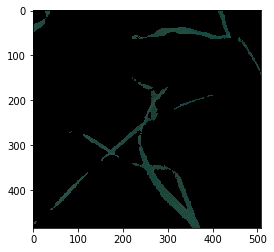

In [12]:
plt.show()

In [26]:
with t.no_grad():    
    preds = []
    names = [] 
    model.eval()
    for data in tqdm(test_dataloader):
        inputs_,classes = data
        out = model(inputs_)
        #print(out)
        _,pred = t.max(out,1)
        #print(pred)
        out_class = [class_names[pre] for pre in pred]
        preds += list(out_class)
        names += list(classes)
        #print(names)
        #print(preds)
        
        #print(out_class)
        lst.append(list(zip(classes,out_class)))
        #print(lst)

100%|██████████| 199/199 [03:18<00:00,  1.00it/s]


In [29]:
import pandas as pd
submission_dict = {"file":names,
                  'species':preds}

In [41]:
df = pd.DataFrame(submission_dict,index=None)


SyntaxError: can't assign to function call (<ipython-input-41-f56af04612b8>, line 2)

In [42]:
df.to_csv('sub.csv',index=False)

In [ ]:
with t.no_grad():    
    lst = []
    model.eval()
    for data in dataloader['train']:
        inputs_,classes = data
        out = model(inputs_)
        #print(out)
        _,pred = t.max(out,1)
        out_class = [class_names[pre] for pre in pred]
        print('p',out_class)
        true = [class_names[pre] for pre in classes]
        print('t',true)
        
        lst.append(zip(classes,out_class))